# Fashion-MNIST using CNNs and Inception-ResNet-v2

The Fashion-MNIST has 60,000 training samples and 10,000 test samples. Each sample is a 28x28 pixel grayscale (8-bit) image.

Classes:

|Label|Description|
|-----|-----------|
|0|T-shirt/top    |
|1|Trouser        |
|2|Pullover       |
|3|Dress          |
|4|Coat           |
|5|Sandal         |
|6|Shirt          |
|7|Sneaker        |
|8|Bag            |
|9|Ankle boot     |

In [1]:
import os
import io
import PIL
import IPython
import collections
import hashlib
import math
import datetime
import itertools

import scipy.ndimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

## Load the data
Luckily, the Fashion-MNIST dataset is included in Keras, so this is a one-liner.

In [2]:
(x_train_indata, y_train_indata), (x_test_indata, y_test_indata) = fashion_mnist.load_data()

# for kaggle
# data_train = pd.read_csv('../input/fashion-mnist_train.csv')
# data_test = pd.read_csv('../input/fashion-mnist_test.csv')
# rows = 28
# cols = 28
# x_train_indata = np.ascontiguousarray(data_train.iloc[:, 1:])
# x_train_indata = x_train_indata.reshape(x_train_indata.shape[0], rows, cols)
# y_train_indata = np.ascontiguousarray(data_train.iloc[:, 0])
# x_test_indata = np.ascontiguousarray(data_test.iloc[:, 1:])
# x_test_indata = x_test_indata.reshape(x_test_indata.shape[0], rows, cols)
# y_test_indata = np.ascontiguousarray(data_test.iloc[:, 0])

4423680/4422102 [==============================] - 0s 0us/step


## Data integrity

Check that the data looks reasonable by looking at a few random samples from the dataset.

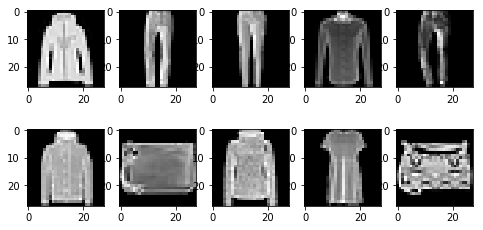

In [3]:
def render_random_images(data, num_samples):
    cols = 5
    rows = math.ceil(num_samples/cols)
    idxs = np.random.choice(len(data), num_samples)
    f, ax = plt.subplots(rows, cols)
    f.set_size_inches(8, 4)
    for i, idx in enumerate(idxs):
        x = i//cols
        y = i%cols
        if rows > 1:
            ax[x, y].imshow(data[idx].reshape(data.shape[1], data.shape[2]), cmap='gray')
        else:
            ax[i].imshow(data[idx].reshape(data.shape[1], data.shape[2]), cmap='gray')
    plt.show()
    
render_random_images(x_train_indata, 10)

### Check for duplicates/overlaps
Does the training data and test data contain duplicates or do they overlap?

In [4]:
def has_duplicates(a):
    ah = [hashlib.sha1(x).hexdigest() for x in a]
    _, counts = np.unique(ah, return_counts=True)    
    if len(collections.Counter(counts).keys()) > 1:
        return True
    return False

print("Duplicates in combined dataset:", has_duplicates(np.concatenate((x_train_indata, x_test_indata))))

Duplicates in combined dataset: False


### Check for class imbalance

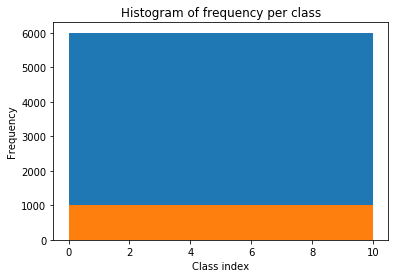

In [5]:
_ = plt.hist(y_train_indata, bins=range(0,11), label="training")
_ = plt.hist(y_test_indata, bins=range(0,11), label="test")

plt.xlabel('Class index')
plt.ylabel('Frequency')
plt.title('Histogram of frequency per class')
plt.show()

The classes are equally common. This was expected, but still good to check.

## Transform data / split

In [6]:
num_classes = 10

# Split the training data into training (50K samples) and validation (10K samples)
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train_indata, 
    y_train_indata, 
    test_size=0.16666, 
    random_state=42)

# Add one dimension because the CNN layers expect n feature maps (color channels)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train = to_categorical(y_train, num_classes=num_classes)
x_validation = x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1)
y_validation = to_categorical(y_validation, num_classes=num_classes)
x_test = x_test_indata.reshape(x_test_indata.shape[0], x_test_indata.shape[1], x_test_indata.shape[2], 1)
y_test = to_categorical(y_test_indata, num_classes=num_classes)

# zero-center and normalize pixels
# preprocess_input is as simple as this:
# x /= 255.
# x -= 0.5
# x *= 2.
x_train = inception_resnet_v2.preprocess_input(x_train)
x_validation = inception_resnet_v2.preprocess_input(x_validation)
x_test = inception_resnet_v2.preprocess_input(x_test)

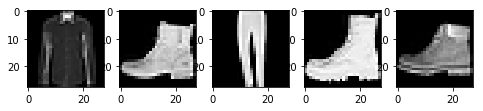

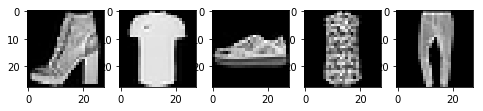

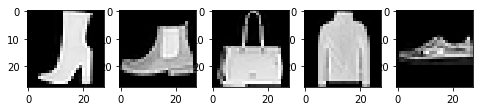

In [7]:
# Re-verify that the images look correct
render_random_images(x_train, 5)
render_random_images(x_validation, 5)
render_random_images(x_test, 5)

### Model definition and training

In [8]:
def eval1d(model):
    score = model.evaluate(np.reshape(x_validation, (x_validation.shape[0], 784)), y_validation, verbose=0)
    for i, _ in enumerate(score):
        print(model.metrics_names[i], score[i])

In [9]:
def eval(model, eval_test=False):
    if eval_test:
        print("Evaluating on TEST data")
        score = model.evaluate(x_test, y_test, verbose=0)
    else:
        print("Evaluating on validation data")
        score = model.evaluate(x_validation, y_validation, verbose=0)
    for i, _ in enumerate(score):
        print(model.metrics_names[i], score[i])

In [10]:
# Simple linear model with only one layer
def model0(learning_rate=0.01, momentum=0.9, decay=1e-6):
    model = Sequential()
    model.add(Dense(num_classes, activation='softmax',input_shape=(784,)))
    model.custom_name = 'model0'
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay, nesterov=False)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("Compiled {} with lr={} momentum={}, decay={}".format(model.custom_name, learning_rate, momentum, decay))
    return model

In [11]:
# Simple model with only one convolutional layer
def model1(learning_rate=0.01, momentum=0.9, decay=1e-6):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1,1), input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.custom_name = 'model1'
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay, nesterov=False)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("Compiled {} with lr={} momentum={}, decay={}".format(model.custom_name, learning_rate, momentum, decay))
    return model

In [12]:
# Deeper model with 3 convolutional layers, max-pooling and dropout
def model2(learning_rate=0.01, momentum=0.9, decay=1e-6):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(16, kernel_size=(2,2)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(16, kernel_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.custom_name = 'model2'
    
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay, nesterov=False)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("Compiled {} with lr={} momentum={}, decay={}".format(model.custom_name, learning_rate, momentum, decay))
    return model

In [13]:
# Train the three models defined above
def run(model, epochs, batch_size, eval_test=False):
    model.summary()
    run_name = datetime.datetime.now().strftime("_%Y-%m-%dT%H_%M_%S")
    tb_cb = tf.keras.callbacks.TensorBoard(log_dir="./graph/" + model.custom_name + run_name,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_images=False,
                                           write_grads=False)
    if model.custom_name == 'model0':
        model.fit(np.reshape(x_train, (x_train.shape[0], 784)),
                  y_train,
                  validation_data=(np.reshape(x_validation, (x_validation.shape[0], 784)), y_validation),
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[tb_cb],
                  verbose=2)
        eval1d(model)
    else:
        model.fit(x_train, 
                  y_train,
                  validation_data=(x_validation, y_validation),
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[tb_cb],
                  verbose=1)
        eval(model, eval_test=eval_test)

In [14]:
tf.keras.backend.clear_session() # Training might crash otherwise
run(model0(), epochs=30, batch_size=32)
tf.keras.backend.clear_session()
run(model1(), epochs=30, batch_size=32)
tf.keras.backend.clear_session()
run(model2(), epochs=30, batch_size=32)

Compiled model0 with lr=0.01 momentum=0.9, decay=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
 - 5s - loss: 0.5780 - acc: 0.8011 - val_loss: 0.5421 - val_acc: 0.8155
Epoch 2/30
 - 4s - loss: 0.5037 - acc: 0.8295 - val_loss: 0.5029 - val_acc: 0.8302
Epoch 3/30
 - 4s - loss: 0.4967 - acc: 0.8330 - val_loss: 0.5660 - val_acc: 0.8140
Epoch 4/30
 - 4s - loss: 0.4713 - acc: 0.8408 - val_loss: 0.4802 - val_acc: 0.8377
Epoch 5/30
 - 4s - loss: 0.4704 - acc: 0.8420 - val_loss: 0.5241 - val_acc: 0.8303
Epoch 6/30
 - 4s - loss: 0.4627 - acc: 0.8403 - val_loss: 0.4873 - val_acc: 0.8357
Epoch 7/30
 - 4s - loss: 0.4536 - acc: 0.8446 - val_loss: 0.5210 

In [15]:
# Preprocess data so that it is compatible with Inception-ResNet-v2.
# Then extract features by running the datasets through Inception-ResNet-v2.
# Finally, cache the files locally so that we don't need to preprocess multiple times.
# This step requires 15-20GB RAM so it could take some time on a low memory machine or create an Out of memory error.
def prepare_img_data_for_inception():
    print('generating...')
    x_train_zoom = scipy.ndimage.zoom(x_train, (1,3,3,1), order=0)
    x_validation_zoom = scipy.ndimage.zoom(x_validation, (1,3,3,1), order=0)
    x_test_zoom = scipy.ndimage.zoom(x_test, (1,3,3,1), order=0)
    x_train_inc = np.repeat(x_train_zoom, 3, axis=3)
    x_validation_inc = np.repeat(x_validation_zoom, 3, axis=3)
    x_train_inc = None
    x_validation_inc = None
    x_test_inc = np.repeat(x_test_zoom, 3, axis=3)
    print('done generating')
    return x_train_inc, x_validation_inc, x_test_inc

def preprocess_inception(x_train_inc, x_validation_inc, x_test_inc):
    print("creating inception model (this takes a while)...")
    inception = inception_resnet_v2.InceptionResNetV2(
                                                    include_top=False,
                                                    weights='imagenet',
                                                    input_tensor=None,
                                                    input_shape=(84,84,3),
                                                    pooling=None)
    print("extracting features from training images...")
    features_train = inception.predict(x_train_inc, verbose=1)
    print("extracting features from validation images...")
    features_validation = inception.predict(x_validation_inc, verbose=1)
    print("extracting features from test images...")
    features_test = inception.predict(x_test_inc, verbose=1)
    print("done extracting")
    # reshape, because predict() returns an array with shape ("num samples", 1, 1, "output layer size")
    features_train = np.reshape(features_train, (features_train.shape[0], features_train.shape[3]))
    features_validation = np.reshape(features_validation, (features_validation.shape[0], features_validation.shape[3]))
    features_train = None
    features_validation = None
    features_test = np.reshape(features_test, (features_test.shape[0], features_test.shape[3]))
    return features_train, features_validation, features_test

def preprocess_or_load():
    feature_file_name1 = 'inception_features_train.npy'
    feature_file_name2 = 'inception_features_validation.npy'
    feature_file_name3 = 'inception_features_test.npy'
    if not (os.path.isfile(feature_file_name1) and os.path.isfile(feature_file_name2) and os.path.isfile(feature_file_name3)):
        x_train_inc, x_validation_inc, x_test_inc = prepare_img_data_for_inception()
        features_train, features_validation, features_test = preprocess_inception(x_train_inc, x_validation_inc, x_test_inc)
        np.save(feature_file_name1, features_train)
        np.save(feature_file_name2, features_validation)
        np.save(feature_file_name3, features_test)
    else:
        features_train = np.load(feature_file_name1)
        features_validation = np.load(feature_file_name2)
        features_test = np.load(feature_file_name3)
    return features_train, features_validation, features_test
    
features_train, features_validation, features_test = preprocess_or_load()

In [16]:
# Define a 2-layer fully connected network as the classifier on top of inceptionnet's features.
def model3(learning_rate=0.01, momentum=0.9, decay=1e-6):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(1536,))) # inception net yeilds 1536 features
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.custom_name = "model3"
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay, nesterov=False)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("Compiled {} with lr={} momentum={}, decay={}".format(model.custom_name, learning_rate, momentum, decay))

    return model

In [17]:
# Train the "transfer learning" model
def run_model3(model, epochs, batch_size, eval_test=False):
    model.summary()
    run_name = datetime.datetime.now().strftime("_%Y-%m-%dT%H_%M_%S")
    tb_cb = tf.keras.callbacks.TensorBoard(log_dir="./graph/" + model.custom_name + run_name,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_images=False,
                                           write_grads=False)
    print("epochs", epochs)
    print("batch_size", batch_size)
    model.fit(features_train,
              y_train,
              validation_data=(features_validation, y_validation),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[tb_cb],
              verbose=1)

    # evaluate model
    if eval_test:
        score = model.evaluate(features_test, y_test, verbose=1)
        print("Evaluating on TEST data")
    else:
        score = model.evaluate(features_validation, y_validation, verbose=1)
        print("Evaluating on validation data")
    for i, _ in enumerate(score):
        print(model.metrics_names[i], score[i])

In [18]:
run_model3(model3(), epochs=30, batch_size=32)

Compiled model3 with lr=0.01 momentum=0.9, decay=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 205,642
Trainable params: 205,642
Non-trainable params: 0
_________________________________________________________________
epochs 30
batch_size 32
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 5s 108us/step - loss: 0.7363 - acc: 0.7386 - val_loss: 0.5562 - val_acc: 0.7961
E

In [19]:
# Perform two grid searches to find better epoch/batch_size and learning_rate/momentum parameters.
# The first run takes ~2h30m on a K80 GPU and the second one 
# Uncomment below to activate

# Support TensorBoard callbacks when running through the KerasClassifer wrapper
# KerasClassifierTB adapted from https://stackoverflow.com/questions/45454905/how-to-use-keras-tensorboard-callback-for-grid-search
class KerasClassifierTB(KerasClassifier):
    def __init__(self, *args, **kwargs):
        super(KerasClassifierTB, self).__init__(*args, **kwargs)

    def fit(self, x, y, log_dir=None, **kwargs):
        cbs = None
        if log_dir is not None:
            # Make sure the base log directory exists
            try:
                os.makedirs(log_dir)
            except OSError:
                pass
            params = self.get_params()
            params.pop("build_fn", None)
            conf = ",".join("{}={}".format(k, params[k])
                            for k in sorted(params))
            conf_dir_base = os.path.join(log_dir, conf)
            # Find a new directory to place the logs
            try:
                d_string = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
                conf_dir = "{}_{}".format(conf_dir_base, d_string)
                os.makedirs(conf_dir)
            except OSError:
                pass
            cbs = [TensorBoard(log_dir=conf_dir, histogram_freq=0,
                               write_graph=False, write_images=False)]
        super(KerasClassifierTB, self).fit(x, y, callbacks=cbs, **kwargs)

# Grid search code adapted from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
def run_grid_search_e_bs(model_name, model_fn, param_grid, x, y):
    model_wrapper = KerasClassifierTB(build_fn=model_fn, verbose=2)
    grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, n_jobs=1, cv=3)
    grid_result = grid.fit(x, y, log_dir="./graph/{}".format(model_name))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

        
def search_e_bs():
    np.random.seed(7) # for reproducibility
    param_grid = {
        "batch_size": [16, 32, 128, 512, 2048],
        "epochs": [10, 30, 50]
    }
    run_grid_search_e_bs("model2", model2, param_grid, x_train, y_train)
    run_grid_search_e_bs("model3", model3, param_grid, features_train, y_train)
    np.random.seed(None)
# Uncomment to run
# search_e_bs()

def run_grid_search_lr_m(model_name, model_fn, param_grid, x, y):
    model_wrapper = KerasClassifierTB(build_fn=model_fn, verbose=2, batch_size=128, epochs=50)
    grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, n_jobs=1, cv=3)
    grid_result = grid.fit(x, y, log_dir="./graph/{}".format(model_name))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

def search_lr_m():
    np.random.seed(7) # for reproducibility
    param_grid = {
        "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "momentum": [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
    }
    run_grid_search_lr_m("model2", model2, param_grid, x_train, y_train)
    run_grid_search_lr_m("model3", model3, param_grid, features_train, y_train)
    np.random.seed(None)
# Uncomment to run
# search_lr_m()

In [20]:
# Final training with "best" parameters and evaluation against test set
# model2: Best: 0.898540 using {'learning_rate': 0.01, 'momentum': 0.8}
# model3: Best: 0.863560 using {'learning_rate': 0.001, 'momentum': 0.9}
epochs = 50
batch_size = 128
run(
    model2(
        learning_rate=0.01, momentum=0.8),
    epochs=epochs, batch_size=batch_size, eval_test=True)
run_model3(
    model3(
        learning_rate=0.001, momentum=0.9
    ), epochs=epochs, batch_size=batch_size, eval_test=True)

Compiled model2 with lr=0.01 momentum=0.8, decay=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 16)        2064      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 16)          1040      
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)      

In [21]:
epochs = 100
batch_size = 128
m2 = model2(learning_rate=0.01, momentum=0.8)
run(m2, epochs=epochs, batch_size=batch_size, eval_test=True)
m3 = model3(learning_rate=0.001, momentum=0.9)
run_model3(m3, epochs=epochs, batch_size=batch_size, eval_test=True)

Compiled model2 with lr=0.01 momentum=0.8, decay=1e-06
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 16)        2064      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 16)          1040      
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_10 (Dense)     

             precision    recall  f1-score   support

T-shirt/top       0.88      0.83      0.85      1000
    Trouser       0.99      0.96      0.98      1000
   Pullover       0.88      0.80      0.84      1000
      Dress       0.91      0.89      0.90      1000
       Coat       0.82      0.89      0.86      1000
     Sandal       0.99      0.96      0.97      1000
      Shirt       0.70      0.78      0.74      1000
    Sneaker       0.91      0.99      0.95      1000
        Bag       0.98      0.97      0.97      1000
 Ankle boot       0.98      0.94      0.96      1000

avg / total       0.90      0.90      0.90     10000



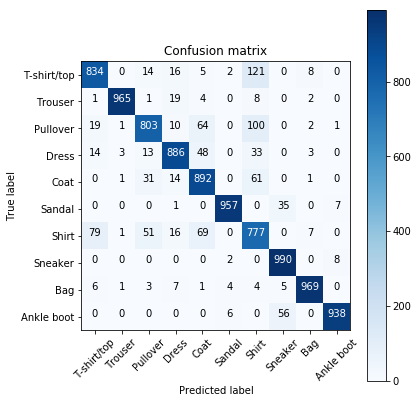

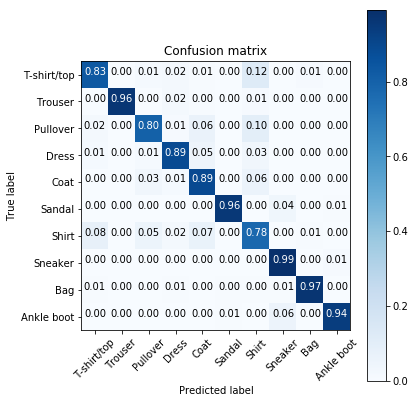

In [70]:
# Plot metrics and confusion matrix
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

y_pred_classes = np.argmax(m2.predict(x_test), axis=1)
y_test_classes = np.argmax(y_test, axis=1)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
print(classification_report(y_test_classes, y_pred_classes, target_names=classes))

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes, normalize=True)
plt.savefig('confusion_matrix.png', format='png', dpi=150)
plt.show()